# Understanding Guitar Tablature and Popularity

### Introduction:

###### Objective:
The objective of this project is to learn what makes guitar tablature popular in relation to attributes of a song and the portrayal of the guitar tablature itself. After learning what makes a tablature popular, we will go back through the data and make actionable recommendations on what other songs would, based on our findings, gain reasonable traction on the website ultimate-guitar.com.

###### Data Description:
The datasets we will be using are both open-source datasets pulled from Kaggle.com. The first was webscraped from the top 850 tablatures on ultimate-guitar.com. This data can be found [here](https://www.kaggle.com/datasets/thomaskonstantin/top-850-guitar-tabs). The other dataset I will be using was pulled from Spotify APIs. It contains metadata revealing details about 440,000 of the top songs. This data can be found [here](https://www.kaggle.com/datasets/luckey01/test-data-set).

###### Limitations:
Some limitations of this dataset are as follows:
- There are no unique IDs for for the ultimate-guitar rows of data. This means there are no unique IDs that corresponds to unique IDs in the Spotify Data. Therefore, the data is not easily joinable, and some rows will simply be unable to be joined.
- The Guitar Tabs data is from 2019, while the Spotify data is newer. Thus, the Guitar Tabs data does not reflect the current state of ultimate-guitar.com perfectly for 2022.
- This analysis uses only metadata about the music and the tablature itself. There is no measure for quality of the tablature in our data and there is no user data about the guitar players that use ultimate-guitar.com. These factors could be a large predicter in popularity for tablature, but we have no way to measure this.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
guitardb = pd.read_csv('OneDrive/Personal Data Projects/Guitar Tabs/GutiarDB.CSV')

In [3]:
spotifydb = pd.read_csv("OneDrive/Personal Data Projects/Guitar Tabs/spotify_tracks_metadata.csv")

## Familiarizing Myself with the Data:
#### Guitar Tab Data:

In [165]:
guitardb.head()

,Artist,Song Name,Song Rating,Song Hits,Page Type,Difficulty,Key,Capo,Tuning
0,Jeff Buckley,Hallelujah,"40,045","31,174,526",Chords,novice,Db,1st fret,E A D G B E
1,Ed Sheeran,Perfect,"31,694","25,794,778",Chords,novice,Ab,1st fret,E A D G B E
2,John Legend,All Of Me,"20,169","25,653,362",Chords,novice,Fm,1st fret,E A D G B E
3,Passenger,Let Her Go,"17,267","24,556,593",Chords,novice,Em,7th fret,E A D G B E
4,Led Zeppelin,Stairway To Heaven,"11,839","20,762,763",Tab,intermediate,Am,No Capo,E A D G B E


In [166]:
guitardb.describe()

,Artist,Song Name,Song Rating,Song Hits,Page Type,Difficulty,Key,Capo,Tuning
count,850,850,850,850,850,850,850,850,850
unique,342,752,751,849,5,6,30,16,18
top,Taylor Swift,Wonderwall,"2,473","1,556,006",Chords,intermediate,Db,No Capo,E A D G B E
freq,27,4,4,2,680,510,235,549,616


In [167]:
guitardb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Artist       850 non-null    object
 1   Song Name    850 non-null    object
 2   Song Rating  850 non-null    object
 3   Song Hits    850 non-null    object
 4   Page Type    850 non-null    object
 5   Difficulty   850 non-null    object
 6   Key          850 non-null    object
 7   Capo         850 non-null    object
 8   Tuning       850 non-null    object
dtypes: object(9)
memory usage: 59.9+ KB


In [207]:
# We can see there are no nulls above. Confirming this is accurate by using the information below.
guitardb.isnull().sum()

artist_name    0
song_name      0
song_rating    0
song_hits      0
page_type      0
Difficulty     0
Key            0
Capo           0
Tuning         0
dtype: int64

In [169]:
# Checking for unnecessary categories and spelling errors in categorical data:
guitardb['Difficulty'].value_counts()

intermediate    510
novice          326
advanced          5
novic             5
intermediat       3
advance           1
Name: Difficulty, dtype: int64

In [170]:
guitardb['Page Type'].value_counts()

Chords        680
Tab           156
Bass           10
Ukulele         2
Guitar Pro      2
Name: Page Type, dtype: int64

In [171]:
guitardb[guitardb.duplicated(['Song Name', 'Artist'])].count()

Artist         85
Song Name      85
Song Rating    85
Song Hits      85
Page Type      85
Difficulty     85
Key            85
Capo           85
Tuning         85
dtype: int64

###### Comments and Concerns
- I noticed that columns "song ratings" and "song hits," are supposed to be numerical integers. They are appearing as "objects."
- I noticed that there are some columns that will not be necessary in my analysis and column names are not in a very Python friendly format.
- I noticed there are a few instances in which the categorical data is misspelled or contains categories that are not relevant.
- There are instances of duplicate values for Song Name and Artist. Even though these are different "tablatures", this analysis is about songs. These duplicates will have to be removed.
- Luckily, there are no null values.
- The things mentioned above will have to be fixed during data cleaning.

#### Spotify Data:

In [172]:
spotifydb.info()

#Looks like there are no Nulls and all the Data Types look correct. There are useless columns.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 439893 entries, 0 to 439892
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Unnamed: 0               439893 non-null  int64  
 1   spotify_id               439893 non-null  object 
 2   song_name                439891 non-null  object 
 3   artist_name              439884 non-null  object 
 4   song_popularity          439893 non-null  int64  
 5   album_release_date       439893 non-null  object 
 6   album_release_year       439690 non-null  float64
 7   album_release_month      420559 non-null  float64
 8   analysis_url             439893 non-null  object 
 9   acousticness             439893 non-null  float64
 10  danceability             439893 non-null  float64
 11  duration_ms              439893 non-null  float64
 12  energy                   439893 non-null  float64
 13  instrumentalness         439893 non-null  float64
 14  key 

In [173]:
spotifydb.head(15)

,Unnamed: 0,spotify_id,song_name,artist_name,song_popularity,album_release_date,album_release_year,album_release_month,analysis_url,acousticness,...,loudness,mode,song_explicit,speechiness,tempo,time_signature,total_available_markets,track_href,uri,valence
0,0,7lPN2DXiMsVn7XUKtOW1CS,drivers license,Olivia Rodrigo,100,2021-01-08,2021.0,1.0,https://api.spotify.com/v1/audio-analysis/7lPN...,0.72100,...,-8.761,1.0,True,0.0601,143.874,4.0,170,https://api.spotify.com/v1/tracks/7lPN2DXiMsVn...,spotify:track:7lPN2DXiMsVn7XUKtOW1CS,0.132
1,1,5QO79kh1waicV47BqGRL3g,Save Your Tears,The Weeknd,96,2020-03-20,2020.0,3.0,https://api.spotify.com/v1/audio-analysis/5QO7...,0.02120,...,-5.487,1.0,True,0.0309,118.051,4.0,170,https://api.spotify.com/v1/tracks/5QO79kh1waic...,spotify:track:5QO79kh1waicV47BqGRL3g,0.644
2,2,0VjIjW4GlUZAMYd2vXMi3b,Blinding Lights,The Weeknd,96,2020-03-20,2020.0,3.0,https://api.spotify.com/v1/audio-analysis/0VjI...,0.00146,...,-5.934,1.0,False,0.0598,171.005,4.0,170,https://api.spotify.com/v1/tracks/0VjIjW4GlUZA...,spotify:track:0VjIjW4GlUZAMYd2vXMi3b,0.334
3,3,3tjFYV6RSFtuktYl3ZtYcq,Mood (feat. iann dior),24kGoldn,95,2020-07-24,2020.0,7.0,https://api.spotify.com/v1/audio-analysis/3tjF...,0.22100,...,-3.558,0.0,True,0.0369,90.989,4.0,170,https://api.spotify.com/v1/tracks/3tjFYV6RSFtu...,spotify:track:3tjFYV6RSFtuktYl3ZtYcq,0.756
4,4,27OeeYzk6klgBh83TSvGMA,WITHOUT YOU,The Kid LAROI,94,2020-11-06,2020.0,11.0,https://api.spotify.com/v1/audio-analysis/27Oe...,0.21300,...,-7.357,1.0,True,0.0299,93.005,4.0,170,https://api.spotify.com/v1/tracks/27OeeYzk6klg...,spotify:track:27OeeYzk6klgBh83TSvGMA,0.467
5,5,5Kskr9LcNYa0tpt5f0ZEJx,Calling My Phone,Lil Tjay,94,2021-02-12,2021.0,2.0,https://api.spotify.com/v1/audio-analysis/5Ksk...,0.45100,...,-7.636,0.0,True,0.0539,104.949,4.0,170,https://api.spotify.com/v1/tracks/5Kskr9LcNYa0...,spotify:track:5Kskr9LcNYa0tpt5f0ZEJx,0.202
6,6,3Ofmpyhv5UAQ70mENzB277,Astronaut In The Ocean,Masked Wolf,94,2021-01-06,2021.0,1.0,https://api.spotify.com/v1/audio-analysis/3Ofm...,0.17500,...,-6.865,0.0,False,0.0913,149.996,4.0,169,https://api.spotify.com/v1/tracks/3Ofmpyhv5UAQ...,spotify:track:3Ofmpyhv5UAQ70mENzB277,0.472
7,7,6f3Slt0GbA2bPZlz0aIFXN,The Business,Tiësto,94,2020-09-16,2020.0,9.0,https://api.spotify.com/v1/audio-analysis/6f3S...,0.41400,...,-7.079,0.0,False,0.2320,120.031,4.0,170,https://api.spotify.com/v1/tracks/6f3Slt0GbA2b...,spotify:track:6f3Slt0GbA2bPZlz0aIFXN,0.235
8,8,1xK1Gg9SxG8fy2Ya373oqb,Bandido,Myke Towers,94,2020-12-10,2020.0,12.0,https://api.spotify.com/v1/audio-analysis/1xK1...,0.12200,...,-4.637,1.0,False,0.0887,168.021,4.0,169,https://api.spotify.com/v1/tracks/1xK1Gg9SxG8f...,spotify:track:1xK1Gg9SxG8fy2Ya373oqb,0.682
9,9,3YJJjQPAbDT7mGpX3WtQ9A,Good Days,SZA,93,2020-12-25,2020.0,12.0,https://api.spotify.com/v1/audio-analysis/3YJJ...,0.49900,...,-8.370,0.0,True,0.0583,121.002,4.0,170,https://api.spotify.com/v1/tracks/3YJJjQPAbDT7...,spotify:track:3YJJjQPAbDT7mGpX3WtQ9A,0.412


In [174]:
spotifydb.describe()

,Unnamed: 0,song_popularity,album_release_year,album_release_month,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,total_available_markets,valence
count,439893.00000,439893.000000,439690.000000,420559.000000,439893.000000,439893.000000,4.398930e+05,439893.000000,439893.000000,439893.000000,439893.000000,439893.000000,439893.000000,439893.000000,439893.000000,439893.000000,439893.000000,439893.000000
mean,219946.00000,22.809390,2014.952946,6.155396,0.332647,0.616870,2.133885e+05,0.584848,0.188697,5.288957,0.209445,-9.960702,0.574342,0.191600,119.238750,3.878545,160.520076,0.475361
std,126986.31532,18.518437,17.427527,3.711844,0.320389,0.178007,1.239932e+05,0.249089,0.338787,3.606797,0.179297,5.897513,0.494443,0.252524,30.200554,0.546340,33.688941,0.253360
min,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,1.864000e+03,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,109973.00000,7.000000,2014.000000,3.000000,0.039700,0.515000,1.540000e+05,0.412000,0.000000,2.000000,0.098900,-12.383000,0.000000,0.042000,95.146000,4.000000,169.000000,0.275000
50%,219946.00000,20.000000,2018.000000,6.000000,0.224000,0.647000,1.993850e+05,0.610000,0.000021,5.000000,0.131000,-8.409000,1.000000,0.071600,120.006000,4.000000,170.000000,0.472000
75%,329919.00000,36.000000,2020.000000,10.000000,0.587000,0.743000,2.473200e+05,0.786000,0.148000,8.000000,0.272000,-5.949000,1.000000,0.232000,139.009000,4.000000,170.000000,0.673000
max,439892.00000,100.000000,2021.000000,12.000000,0.996000,0.994000,6.024647e+06,1.000000,1.000000,11.000000,1.000000,5.285000,1.000000,0.972000,249.810000,5.000000,170.000000,1.000000


In [175]:
spotifydb[spotifydb.duplicated(['song_name', 'artist_name'])].count()

Unnamed: 0                 0
spotify_id                 0
song_name                  0
artist_name                0
song_popularity            0
album_release_date         0
album_release_year         0
album_release_month        0
analysis_url               0
acousticness               0
danceability               0
duration_ms                0
energy                     0
instrumentalness           0
key                        0
liveness                   0
loudness                   0
mode                       0
song_explicit              0
speechiness                0
tempo                      0
time_signature             0
total_available_markets    0
track_href                 0
uri                        0
valence                    0
dtype: int64

###### Comments and Concerns:
- The goal is to join this dataset and guitardb. Column song_name seems to give more description about the song than guitardb's song name. These will have to match each other for a successful join.
- Capitilization does not look standardized.
- No Nulls.
- No Duplicates bassed off both song_name and artist_name.
- Mainly name standardization will need to be fixed in the cleaning phase

## Cleaning Data:
###### Guitar Tabs Data

In [176]:
# Formatting capitalization for consistency
guitardb['Song Name'] = guitardb['Song Name'].str.lower()
guitardb['Page Type'] = guitardb['Page Type'].str.lower()
guitardb['Difficulty'] = guitardb['Difficulty'].str.lower()
guitardb['Artist'] = guitardb['Artist'].str.title()

In [208]:
#Removing commas from numerical data to allow for the use of mathematical formulas
guitardb = guitardb.replace(',','', regex=True)


In [178]:
#Removing unnecessary white space at the beginning and end of strings.
guitardb['Artist'] = guitardb['Artist'].str.strip()
guitardb['Song Name'] = guitardb['Song Name'].str.strip()
guitardb['Page Type'] = guitardb['Page Type'].str.strip()
guitardb['Difficulty'] = guitardb['Difficulty'].str.strip()
guitardb['Tuning'] = guitardb['Tuning'].str.strip()
guitardb

,Artist,Song Name,Song Rating,Song Hits,Page Type,Difficulty,Key,Capo,Tuning
0,Jeff Buckley,hallelujah,40045,31174526,chords,novice,Db,1st fret,E A D G B E
1,Ed Sheeran,perfect,31694,25794778,chords,novice,Ab,1st fret,E A D G B E
2,John Legend,all of me,20169,25653362,chords,novice,Fm,1st fret,E A D G B E
3,Passenger,let her go,17267,24556593,chords,novice,Em,7th fret,E A D G B E
4,Led Zeppelin,stairway to heaven,11839,20762763,tab,intermediate,Am,No Capo,E A D G B E
...,...,...,...,...,...,...,...,...,...
845,Zz Top,beer drinkers and hell raisers,23,1406368,chords,intermediate,Db,No Capo,E A D G B E
846,Weezer,weezer album,9,1406306,tab,intermediate,Db,No Capo,E A D G B E
847,Misc Soundtrack,mission impossible 2 - nyah,7,1406081,tab,intermediate,Db,No Capo,E A D G B
848,Radiohead,fake plastic trees,2448,1406413,chords,intermediate,A,No Capo,E A D G B E


In [5]:
#Renaming column names in a more Python friendly format:
guitardb.rename(columns = {'Artist':'artist_name', 'Song Name':'song_name', 'Song Rating':'song_rating', 
                            'Song Hits':'song_hits', 'Page Type':'page_type'}, inplace=True)

In [180]:
#Fixing spelling errors in categorical data:
guitardb['Difficulty'].replace(['novic', 'intermediat', 'advance'], 
                                                           ['novice', 'intermediate', 'advanced'], inplace =True)
guitardb['Difficulty'].value_counts()

intermediate    513
novice          331
advanced          6
Name: Difficulty, dtype: int64

In [181]:
# Dropping columns that are not either chords or tabs
guitardb = guitardb[guitardb['page_type'].str.contains("tab|chords")]
guitardb['page_type'].value_counts()

chords    680
tab       156
Name: page_type, dtype: int64

In [182]:
# Removing non alphanumeric characters from song_name for joining later.

guitardb['song_name'] = guitardb['song_name'].str.replace(".*( - )","")
guitardb['song_name'] = guitardb['song_name'].str.replace(r"\(.*?\)", "", regex=True)
guitardb['song_name'] = guitardb['song_name'].str.replace('[^0-9a-zA-Z\s]', '')
guitardb['artist_name'] = guitardb['artist_name'].str.strip()
guitardb['song_name'] = guitardb['song_name'].str.strip()
guitardb[guitardb['song_name'].str.contains('-')]
guitardb.head()

C:\Users\Jordan Elliott\AppData\Local\Temp\ipykernel_10880\4243615163.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  guitardb['song_name'] = guitardb['song_name'].str.replace(".*( - )","")
C:\Users\Jordan Elliott\AppData\Local\Temp\ipykernel_10880\4243615163.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  guitardb['song_name'] = guitardb['song_name'].str.replace(".*( - )","")
C:\Users\Jordan Elliott\AppData\Local\Temp\ipykernel_10880\4243615163.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

,artist_name,song_name,song_rating,song_hits,page_type,Difficulty,Key,Capo,Tuning
0,Jeff Buckley,hallelujah,40045,31174526,chords,novice,Db,1st fret,E A D G B E
1,Ed Sheeran,perfect,31694,25794778,chords,novice,Ab,1st fret,E A D G B E
2,John Legend,all of me,20169,25653362,chords,novice,Fm,1st fret,E A D G B E
3,Passenger,let her go,17267,24556593,chords,novice,Em,7th fret,E A D G B E
4,Led Zeppelin,stairway to heaven,11839,20762763,tab,intermediate,Am,No Capo,E A D G B E


In [183]:
# Grouping data to avoid duplicated entries of the same tablature.

guitardb2 = guitardb.groupby(['song_name', 'artist_name', 'Difficulty', 'page_type'], as_index=False)[
    ['song_hits', 'song_rating']].agg(
    lambda x: x.astype(int).sum()).sort_values('song_hits', ascending=False)
guitardb2

,song_name,artist_name,Difficulty,page_type,song_hits,song_rating
222,hallelujah,Jeff Buckley,novice,chords,41964628,47227
315,im yours,Jason Mraz,novice,chords,29309638,14590
27,all of me,John Legend,novice,chords,28426434,24089
728,wonderwall,Oasis,intermediate,chords,28011563,10416
370,let her go,Passenger,novice,chords,27859404,18536
...,...,...,...,...,...,...
424,my heads in mississippi intro,Zz Top,intermediate,tab,1408236,14
608,teenage dream,Katy Perry,intermediate,chords,1406945,298
56,beer drinkers and hell raisers,Zz Top,intermediate,chords,1406368,23
694,weezer album,Weezer,intermediate,tab,1406306,9


###### Spotify Data:

In [184]:
# Dropping Columns that are unnecessary for this analysis:

spotifydb.drop(['spotify_id', 'album_release_date', 'album_release_month', 'analysis_url', 'key', 
                'liveness', 'mode', 'time_signature', 'total_available_markets', 'track_href', 'uri'], axis=1, inplace=True)
spotifydb.rename(columns = {'Unnamed: 0':'ranking'}, inplace=True)
spotifydb

,ranking,song_name,artist_name,song_popularity,album_release_year,acousticness,danceability,duration_ms,energy,instrumentalness,loudness,song_explicit,speechiness,tempo,valence
0,0,drivers license,Olivia Rodrigo,100,2021.0,0.72100,0.585,242014.0,0.436,0.000013,-8.761,True,0.0601,143.874,0.132
1,1,Save Your Tears,The Weeknd,96,2020.0,0.02120,0.680,215627.0,0.826,0.000012,-5.487,True,0.0309,118.051,0.644
2,2,Blinding Lights,The Weeknd,96,2020.0,0.00146,0.514,200040.0,0.730,0.000095,-5.934,False,0.0598,171.005,0.334
3,3,Mood (feat. iann dior),24kGoldn,95,2020.0,0.22100,0.700,140526.0,0.722,0.000000,-3.558,True,0.0369,90.989,0.756
4,4,WITHOUT YOU,The Kid LAROI,94,2020.0,0.21300,0.662,161385.0,0.413,0.000000,-7.357,True,0.0299,93.005,0.467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439888,439888,Aarti Durga Maa Ki,Anuradha Paudwal,0,2021.0,0.41500,0.587,317759.0,0.587,0.000000,-8.828,False,0.0325,89.976,0.564
439889,439889,Aaramangal,K. S. Chithra,0,2021.0,0.52100,0.748,312375.0,0.482,0.000006,-8.669,False,0.0303,113.019,0.910
439890,439890,"Aarti (Lovthavti Vikrala) [From ""Shankara Karu...",Anuradha Paudwal,0,2021.0,0.60800,0.672,126457.0,0.380,0.000000,-10.281,False,0.0349,100.613,0.908
439891,439891,Aa Bhi Jao Ki,Kavita Krishnamurthy,0,2021.0,0.08910,0.777,337536.0,0.556,0.000891,-10.777,False,0.0263,106.999,0.784


In [185]:
# Formatting capitalization for consistency
spotifydb['song_name'] = spotifydb['song_name'].str.lower()
spotifydb['artist_name'] = spotifydb['artist_name'].str.title()

In [186]:
#Removing extra characters and white spaces to allow a join with the guitardb dataset.

spotifydb['song_name'] = spotifydb['song_name'].str.replace(r"\(.*?\)", "", regex=True)
spotifydb['song_name'] = spotifydb['song_name'].str.replace("( - ).*","")
spotifydb['song_name'] = spotifydb['song_name'].str.replace("(-).*"," ")
spotifydb['song_name'] = spotifydb['song_name'].str.replace('[^0-9a-zA-Z\s]', '')
spotifydb['artist_name'] = spotifydb['artist_name'].str.strip()
spotifydb['song_name'] = spotifydb['song_name'].str.strip()

spotifydb

C:\Users\Jordan Elliott\AppData\Local\Temp\ipykernel_10880\577084185.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  spotifydb['song_name'] = spotifydb['song_name'].str.replace("( - ).*","")
C:\Users\Jordan Elliott\AppData\Local\Temp\ipykernel_10880\577084185.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  spotifydb['song_name'] = spotifydb['song_name'].str.replace("(-).*"," ")
C:\Users\Jordan Elliott\AppData\Local\Temp\ipykernel_10880\577084185.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  spotifydb['song_name'] = spotifydb['song_name'].str.replace('[^0-9a-zA-Z\s]', '')


,ranking,song_name,artist_name,song_popularity,album_release_year,acousticness,danceability,duration_ms,energy,instrumentalness,loudness,song_explicit,speechiness,tempo,valence
0,0,drivers license,Olivia Rodrigo,100,2021.0,0.72100,0.585,242014.0,0.436,0.000013,-8.761,True,0.0601,143.874,0.132
1,1,save your tears,The Weeknd,96,2020.0,0.02120,0.680,215627.0,0.826,0.000012,-5.487,True,0.0309,118.051,0.644
2,2,blinding lights,The Weeknd,96,2020.0,0.00146,0.514,200040.0,0.730,0.000095,-5.934,False,0.0598,171.005,0.334
3,3,mood,24Kgoldn,95,2020.0,0.22100,0.700,140526.0,0.722,0.000000,-3.558,True,0.0369,90.989,0.756
4,4,without you,The Kid Laroi,94,2020.0,0.21300,0.662,161385.0,0.413,0.000000,-7.357,True,0.0299,93.005,0.467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439888,439888,aarti durga maa ki,Anuradha Paudwal,0,2021.0,0.41500,0.587,317759.0,0.587,0.000000,-8.828,False,0.0325,89.976,0.564
439889,439889,aaramangal,K. S. Chithra,0,2021.0,0.52100,0.748,312375.0,0.482,0.000006,-8.669,False,0.0303,113.019,0.910
439890,439890,aarti from shankara karunakara,Anuradha Paudwal,0,2021.0,0.60800,0.672,126457.0,0.380,0.000000,-10.281,False,0.0349,100.613,0.908
439891,439891,aa bhi jao ki,Kavita Krishnamurthy,0,2021.0,0.08910,0.777,337536.0,0.556,0.000891,-10.777,False,0.0263,106.999,0.784


In [187]:
spotifydb['song_name'].str.contains('-').sum()

0

## Analysis:
#### Just Guitar Tabs Data:

In [188]:
#Grouping everything by difficulty, page type, and artist for analysis.

difficultycount = guitardb2.groupby(['Difficulty'], as_index=False)['song_hits'].count()
difficultysum = guitardb2.groupby(['Difficulty'], as_index=False)['song_hits'].sum()
pagetypecount = guitardb2.groupby(['page_type'], as_index=False)['song_hits'].count()
pagetypesum = guitardb2.groupby(['page_type'], as_index=False)['song_hits'].sum()
artistcount = guitardb2.groupby(['artist_name'], as_index=False)['song_hits'].count()
artistsum = guitardb2.groupby(['artist_name'], as_index=False)['song_hits'].sum()
difficultycount

,Difficulty,song_hits
0,advanced,5
1,intermediate,464
2,novice,295


In [189]:
# I also want to compare all songs on the difficulty and page type lists 
# with the top 100 songs seperately to see if the numbers and percentages are different.

guitardb2head = guitardb2.head(100)

difficultycounthead = guitardb2head.groupby(['Difficulty'], as_index=False)['song_hits'].count()
difficultysumhead = guitardb2head.groupby(['Difficulty'], as_index=False)['song_hits'].sum()
pagetypecounthead = guitardb2head.groupby(['page_type'], as_index=False)['song_hits'].count()
pagetypesumhead = guitardb2head.groupby(['page_type'], as_index=False)['song_hits'].sum()
difficultysumhead

,Difficulty,song_hits
0,advanced,9054292
1,intermediate,406899691
2,novice,682452659


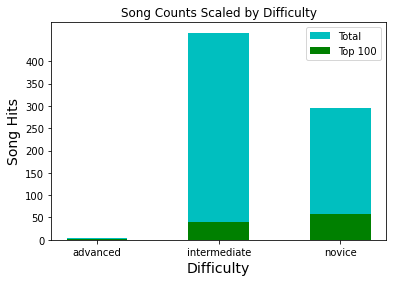

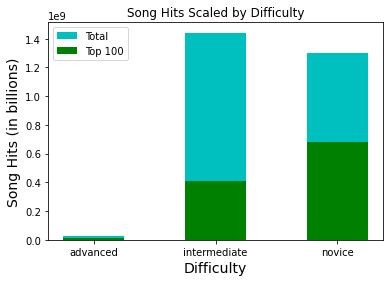

In [190]:
# Plotting the top Song Counts and Song Hits(views) by difficulty.
# The green bar represents the top 100, while the blue bar represents the total.

plt.bar(x = difficultycount['Difficulty'], height = difficultycount['song_hits'], color = 'c', width = .5, label = 'Total')
plt.bar(difficultycounthead['Difficulty'], difficultycounthead['song_hits'], color = 'g', width =.5, label = 'Top 100')
plt.title('Song Counts Scaled by Difficulty')
plt.xlabel('Difficulty', size = 14)
plt.ylabel('Song Hits', size = 14)
plt.yticks(np.arange(0, 450, 50))
plt.legend()
plt.show()

plt.bar(x = difficultysum['Difficulty'], height = difficultysum['song_hits'], color = 'c', width = .5, label = 'Total')
plt.bar(difficultysumhead['Difficulty'], difficultysumhead['song_hits'], color = 'g', width = .5, label = 'Top 100')
plt.title('Song Hits Scaled by Difficulty')
plt.xlabel('Difficulty', size = 14)
plt.ylabel('Song Hits (in billions)', size = 14)
plt.legend()
plt.show()

##### Graph Explanation - Difficulty
These Graphs above, Song Counts/Song Hits by Difficulty, show that, out of the total 850 rows of data in guitardb, intermediate is the most popular both by song count and song hits.
However, it is different for the top 100. Novice songs get the most popularity within the top 100. Having slightly more instances in the top 100, and having 350-400 million more song hits.

In [191]:
pagetypesum

,page_type,song_hits
0,chords,2266485759
1,tab,499411045


In [192]:
pagetypecount

,page_type,song_hits
0,chords,619
1,tab,145


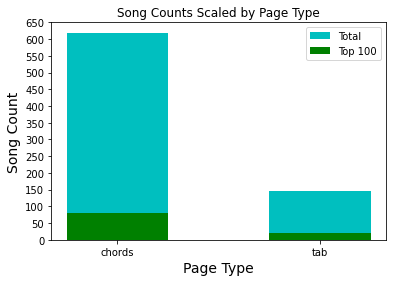

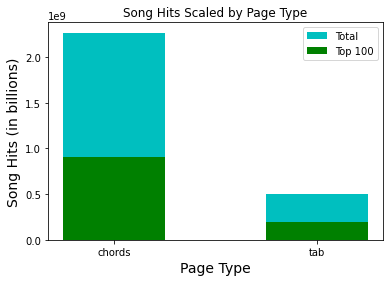

In [193]:
#Similar concept as above but for Page Type

plt.bar(x = pagetypecount['page_type'], height = pagetypecount['song_hits'], color = 'c', width = .5, label = 'Total')
plt.bar(pagetypecounthead['page_type'], pagetypecounthead['song_hits'], color = 'g', width =.5, label = 'Top 100')
plt.title('Song Counts Scaled by Page Type')
plt.xlabel('Page Type', size = 14)
plt.ylabel('Song Count', size = 14)
plt.yticks(np.arange(0, 700, 50))
plt.legend()
plt.show()

plt.bar(x = pagetypesum['page_type'], height = pagetypesum['song_hits'], color = 'c', width = .5, label = 'Total')
plt.bar(pagetypesumhead['page_type'], pagetypesumhead['song_hits'], color = 'g', width =.5, label = 'Top 100')
plt.title('Song Hits Scaled by Page Type')
plt.xlabel('Page Type', size = 14)
plt.ylabel('Song Hits (in billions)', size = 14)
plt.legend()
plt.show()

##### Graph Explanation - Page Type
In every account for this one. It seems like chords are far more popular than tabs.

Text(0.5, 1.0, 'Song Ratings & Hits Correlation')

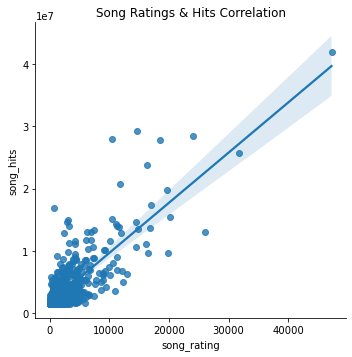

In [194]:
#Correlating Song Hits and Song Rating

sns.lmplot(x = 'song_rating', y = 'song_hits', data = guitardb2, fit_reg=True)
plt.title('Song Ratings & Hits Correlation')

###### Graph Explanation - Correlation
There is a strong correlation between Song Ratings and Song Hits, as we would expect. The more popular a guitar tab becomes, the more people are going to be rating it.

In [195]:
#Grouping everything by Artists.

artistsum = artistsum.sort_values('song_hits', ascending=False).head(15)
artistcount = artistcount.sort_values('song_hits', ascending=False).head(15)
artistjoin = artistsum.merge(artistcount, left_on=['artist_name'], right_on=['artist_name'], how='inner')
artistjoin.rename(columns = {'song_hits_x':'song_hits', 'song_hits_y':'song_count'}, inplace=True)
artistjoin

,artist_name,song_hits,song_count
0,Ed Sheeran,138233698,22
1,The Beatles,86514051,22
2,Taylor Swift,80558010,26
3,Adele,67710022,11
4,Metallica,66910795,12
5,Bruno Mars,59080147,10
6,Jason Mraz,55690785,9
7,Coldplay,55405313,8
8,Green Day,50733038,12
9,Red Hot Chili Peppers,39686163,9


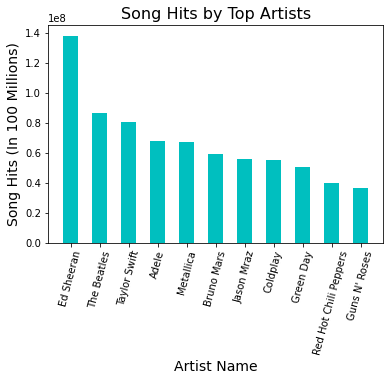

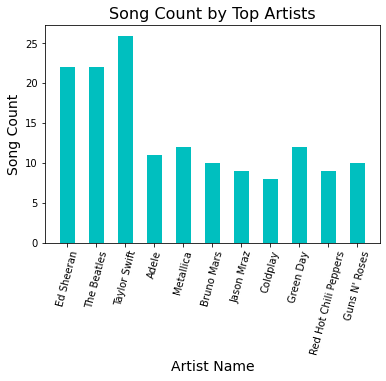

In [196]:
plt.bar(x = artistjoin['artist_name'], height = artistjoin['song_hits'], color = 'c', width = .5)
plt.title('Song Hits by Top Artists', size=16)
plt.xlabel('Artist Name', size = 14)
plt.ylabel('Song Hits (In 100 Millions)', size = 14)
plt.xticks(rotation=75)
plt.show()

plt.bar(x = artistjoin['artist_name'], height = artistjoin['song_count'], color = 'c', width = .5)
plt.title('Song Count by Top Artists', size=16)
plt.xlabel('Artist Name', size = 14)
plt.ylabel('Song Count', size = 14)
plt.xticks(rotation=75)
plt.show()

###### Graph Explanation - Artists
This one is pretty self explanatory. It seems like Ed Sheeran, Tayor Swift, and the Beatles are the most popular artists found on the guitardb dataset. Ed Sheeran is the most popular artist based on Song Hits, despite Taylor Swift having the highest Song Count by two.

#### Spotify Data Analysis:

In [197]:
spotifydb.corr()

,ranking,song_popularity,album_release_year,acousticness,danceability,duration_ms,energy,instrumentalness,loudness,song_explicit,speechiness,tempo,valence
ranking,1.000000,-0.973878,0.048145,0.061634,-0.015522,0.035487,-0.088986,0.093646,-0.143186,0.001096,0.120557,-0.002590,-0.005279
song_popularity,-0.973878,1.000000,-0.047256,-0.067072,0.018864,-0.030250,0.084917,-0.095371,0.147129,0.013380,-0.133875,0.005064,-0.000555
album_release_year,0.048145,-0.047256,1.000000,-0.044549,0.072431,-0.057172,0.007354,0.025876,0.015472,0.089693,0.026470,0.012507,-0.047620
acousticness,0.061634,-0.067072,-0.044549,1.000000,-0.284110,-0.065813,-0.637152,0.138082,-0.526285,-0.160475,0.120617,-0.198493,-0.124760
danceability,-0.015522,0.018864,0.072431,-0.284110,1.000000,-0.114180,0.176870,-0.242311,0.277236,0.255947,0.197709,0.023292,0.412118
duration_ms,0.035487,-0.030250,-0.057172,-0.065813,-0.114180,1.000000,0.079004,0.090461,0.069347,-0.100772,-0.187665,0.038249,-0.102922
energy,-0.088986,0.084917,0.007354,-0.637152,0.176870,0.079004,1.000000,-0.210131,0.775302,0.081744,-0.155518,0.204518,0.294320
instrumentalness,0.093646,-0.095371,0.025876,0.138082,-0.242311,0.090461,-0.210131,1.000000,-0.375424,-0.241757,-0.263045,-0.010087,-0.277828
loudness,-0.143186,0.147129,0.015472,-0.526285,0.277236,0.069347,0.775302,-0.375424,1.000000,0.153895,-0.208774,0.187253,0.277513
song_explicit,0.001096,0.013380,0.089693,-0.160475,0.255947,-0.100772,0.081744,-0.241757,0.153895,1.000000,0.081637,0.036244,-0.001238


**Notes on correlation to look out for:**
- Energy, Loudness, and Valence (how happy the song sounds) all have a moderate correlation.
- Danceability has a moderate correlation to Valence
- Acousticness has a moderate negative correlation to energy and loudness.
- There are no direct correlations to popularity, surprisingly.

#### Guitar and Spotify Data

In [198]:
#Removing more columns that are not necessary to compare to the Spotify dataset

guitardb3 = guitardb.groupby(['song_name', 'artist_name'], as_index=False)['song_hits'].agg(
    lambda x: x.astype(int).sum()).sort_values('song_hits', ascending=False)
guitardb3

,song_name,artist_name,song_hits
194,hallelujah,Jeff Buckley,45808607
271,im yours,Jason Mraz,40869624
637,wonderwall,Oasis,36525228
321,let her go,Passenger,29285064
25,all of me,John Legend,28426434
...,...,...,...
372,my heads in mississippi intro,Zz Top,1408236
535,teenage dream,Katy Perry,1406945
54,beer drinkers and hell raisers,Zz Top,1406368
607,weezer album,Weezer,1406306


In [199]:
#Performing a left Join on the two datasets to gain more insights about the guitardb songs.

spotifydb2 = spotifydb.groupby(['song_name', 'artist_name']).first()
dfjoin = guitardb3.merge(spotifydb2, left_on=['song_name', 'artist_name'], right_on=['song_name', 'artist_name'], how='left')
dfjoin.head(15)

,song_name,artist_name,song_hits,ranking,song_popularity,album_release_year,acousticness,danceability,duration_ms,energy,instrumentalness,loudness,song_explicit,speechiness,tempo,valence
0,hallelujah,Jeff Buckley,45808607,3177.0,72.0,1994.0,0.93100,0.324,413827.0,0.136,0.001170,-10.330,False,0.0318,97.256,0.0831
1,im yours,Jason Mraz,40869624,329.0,82.0,2008.0,0.59500,0.686,242187.0,0.457,0.000000,-8.322,False,0.0468,150.953,0.7180
2,wonderwall,Oasis,36525228,529.0,80.0,1995.0,0.00236,0.410,258907.0,0.854,0.000000,-5.609,False,0.0366,174.584,0.4560
3,let her go,Passenger,29285064,7689.0,66.0,2013.0,0.36500,0.479,252733.0,0.545,0.000000,-7.346,False,0.0688,74.897,0.2440
4,all of me,John Legend,28426434,98.0,86.0,2013.0,0.92200,0.422,269560.0,0.264,0.000000,-7.064,False,0.0322,119.930,0.3310
5,wish you were here,Pink Floyd,28077014,4131.0,70.0,1975.0,0.73500,0.481,334744.0,0.262,0.011400,-15.730,False,0.0414,122.883,0.3750
6,perfect,Ed Sheeran,25794778,110.0,86.0,2017.0,0.16300,0.599,263400.0,0.448,0.000000,-6.312,False,0.0232,95.050,0.1680
7,hey there delilah,Plain White T'S,25718486,507.0,80.0,2005.0,0.87200,0.656,232533.0,0.291,0.000000,-10.572,False,0.0293,103.971,0.2980
8,thinking out loud,Ed Sheeran,25312913,249.0,83.0,2014.0,0.47400,0.781,281560.0,0.445,0.000000,-6.061,False,0.0295,78.998,0.5910
9,hotel california,Eagles,22452423,259.0,83.0,1976.0,0.00574,0.579,391376.0,0.508,0.000494,-9.484,False,0.0270,147.125,0.6090


In [200]:
dfjoin.count()

song_name             664
artist_name           664
song_hits             664
ranking               503
song_popularity       503
album_release_year    503
acousticness          503
danceability          503
duration_ms           503
energy                503
instrumentalness      503
loudness              503
song_explicit         503
speechiness           503
tempo                 503
valence               503
dtype: int64

##### Missing Value Explanation
- After combining the two tables, around 150 of the songs listed are unusable when joined.
- The main reason for this is naming conventions: Some creators will say things in their title like "Perfect **Acoustic**" when making popular guitar tabs. Or the Spotify dataset may add a "The" in the front of an Artist's name that isn't present in the other dataset. Things like this are very difficult to account for. Accounting for all of these instances without compromising data accuracy is very difficult, near impossible.
- As well, there are going to be instances, even in this large of a dataset, where a song in the guitardb dataset may not present in the Spotify dataset. There's not much that can be done about this.

- We will continue this part of the analysis with the 503 usable rows of data, which is still a very valid number for analysis.

In [201]:
#Removing Rows that could not be joined.

dfjoin.dropna(inplace=True)
dfjoin.isnull().sum()

song_name             0
artist_name           0
song_hits             0
ranking               0
song_popularity       0
album_release_year    0
acousticness          0
danceability          0
duration_ms           0
energy                0
instrumentalness      0
loudness              0
song_explicit         0
speechiness           0
tempo                 0
valence               0
dtype: int64

In [202]:
dfjoin.describe()

,song_hits,ranking,song_popularity,album_release_year,acousticness,danceability,duration_ms,energy,instrumentalness,loudness,speechiness,tempo,valence
count,5.030000e+02,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000
mean,4.604313e+06,7421.777336,72.660040,2000.029821,0.302796,0.539165,246817.242545,0.577818,0.014805,-7.774256,0.049040,121.027171,0.444461
std,5.331998e+06,29207.092573,9.568673,16.267348,0.308265,0.141830,63524.146115,0.218522,0.064797,3.436445,0.040096,29.179626,0.226429
min,1.406945e+06,28.000000,0.000000,1942.000000,0.000007,0.149000,117493.000000,0.054900,0.000000,-20.567000,0.023200,48.718000,0.036300
25%,1.879091e+06,819.500000,69.000000,1991.000000,0.028450,0.437000,208749.500000,0.412000,0.000000,-9.611000,0.030050,96.551500,0.256500
50%,2.640636e+06,2095.000000,74.000000,2006.000000,0.179000,0.547000,237747.000000,0.596000,0.000004,-7.060000,0.036100,120.021000,0.420000
75%,4.795395e+06,5139.000000,78.000000,2012.000000,0.569000,0.636500,269466.500000,0.752500,0.000320,-5.168500,0.049450,140.052500,0.603000
max,4.580861e+07,405449.000000,90.000000,2021.000000,0.978000,0.885000,536067.000000,0.995000,0.723000,-2.260000,0.438000,205.846000,0.969000


In [203]:
# Looking at correlation data

dfjoin.corr()['song_hits'].sort_values(ascending=False)

song_hits             1.000000
song_popularity       0.219102
acousticness          0.161578
duration_ms           0.158178
instrumentalness     -0.009475
album_release_year   -0.021764
danceability         -0.044745
speechiness          -0.067328
tempo                -0.072708
ranking              -0.078904
loudness             -0.112830
valence              -0.131894
energy               -0.186653
Name: song_hits, dtype: float64

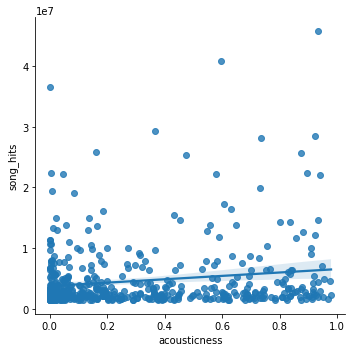

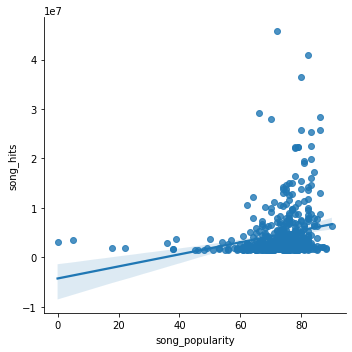

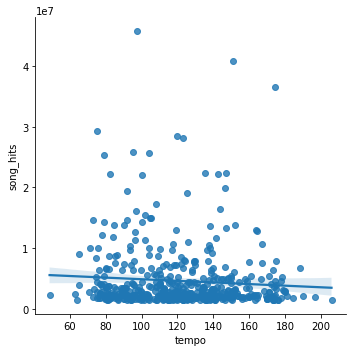

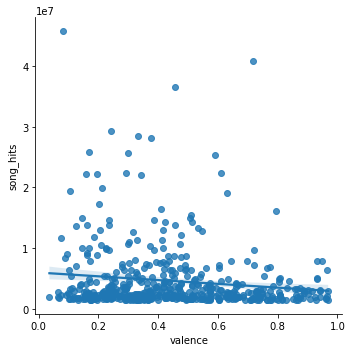

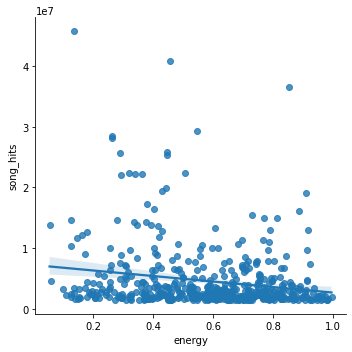

In [204]:
#Plotting correlations

sns.lmplot(y = 'song_hits', x = 'acousticness', data=dfjoin)
sns.lmplot(y = 'song_hits', x = 'song_popularity', data=dfjoin)
sns.lmplot(y = 'song_hits', x = 'tempo', data=dfjoin)
sns.lmplot(y = 'song_hits', x = 'valence', data=dfjoin)
sns.lmplot(y = 'song_hits', x = 'energy', data=dfjoin)

###### Correlation Explanation:
- None of these are strongly correlated, but there are some weaker correlations to note.
- The three strongest correlations are a positive correlation between song hits and popularity, a positive correlation between song hits and acousticness, and a negative correlation between song hits and energy.
- This means that a song will have the highest chance of having a popular guitar tab on guitartabs.com if it is low on energy, high in acousticness, and is popular.

## Conclusions:

###### Making Successful Guitar Tablature:
   Based on the data, these are my recommendations to anybody who wishes to make successful guitar tablature on guitartabs.com:

###### Tablature:

- **Page Type:** We saw earlier that there are significantly more instances of "chords" than there were of "tabs" in the top 850 rows in dataset guitardb. Therefore, creating tablature under page type "chords" will significantly increase your chances of success.
- **Difficulty:** We saw in the data and graphical charts that both "intermediate" and "novice" are most common, while "advanced" only had a total of 6 instances in the data set. "Intermediate" will give a tablature writer the best chance of making it onto the top 850, but to hit the top 100 and have the most song hits, "novice" could give you the most success.

###### Song Choice:

- **Artist:** Songs by Ed Sheeran, the Beatles, and Taylor Swift were the most popular artists in this dataset.
- **Correlations:** Even though the correlations in this experiment are relatively low, there are some slight patterns to observe. The more popular songs tend to be high in popularity, high in acousticness and low in energy.

###### Recommendation:
   Since this data set is a couple of years old, I would look for a 2021 or newer album, written by the top 3 Artists, (excluding the Beatles since they no longer are writing music). I would then pick a song from one of these albums thats attributes match what we have seen in our correlation charts. Lastly, I would create the tablature with its page type being "chords" and its difficulty being intermediate (unless the song is just really easy, then novice could still be a viable option.)
*Some Suggestions on Songs Below:

In [205]:
last = spotifydb[spotifydb['artist_name'].isin(['Ed Sheeran', 'Taylor Swift'])]
last[last['album_release_year'] > 2019].sort_values(['song_popularity', 'acousticness', 'energy'], 
                                                    ascending=[False, False, True])

,ranking,song_name,artist_name,song_popularity,album_release_year,acousticness,danceability,duration_ms,energy,instrumentalness,loudness,song_explicit,speechiness,tempo,valence
55,55,afterglow,Ed Sheeran,88,2020.0,0.69800,0.641,185487.0,0.324,0.000000,-5.851,False,0.0299,110.184,0.273
118,118,willow,Taylor Swift,86,2020.0,0.83300,0.392,214707.0,0.574,0.001790,-9.195,False,0.1700,81.112,0.529
109,109,love story,Taylor Swift,86,2021.0,0.13500,0.626,235767.0,0.790,0.000004,-4.302,False,0.0311,119.082,0.416
416,416,champagne problems,Taylor Swift,81,2020.0,0.92000,0.462,244000.0,0.240,0.000000,-12.077,True,0.0377,171.319,0.320
377,377,cardigan,Taylor Swift,81,2020.0,0.53700,0.613,239560.0,0.581,0.000345,-8.588,False,0.0424,130.033,0.551
627,627,exile,Taylor Swift,80,2020.0,0.77800,0.298,285634.0,0.380,0.000056,-8.426,False,0.0287,75.602,0.152
1225,1225,gold rush,Taylor Swift,77,2020.0,0.83000,0.512,185320.0,0.462,0.166000,-10.491,True,0.0408,112.050,0.353
1136,1136,the 1,Taylor Swift,77,2020.0,0.75700,0.777,210252.0,0.357,0.000007,-6.942,True,0.0522,139.883,0.172
1211,1211,no body no crime,Taylor Swift,77,2020.0,0.41800,0.546,215627.0,0.613,0.000000,-7.589,False,0.0264,79.015,0.535
1766,1766,tolerate it,Taylor Swift,75,2020.0,0.87800,0.316,245440.0,0.361,0.000027,-10.381,True,0.0488,74.952,0.221


###### Recommended Songs:
- **Champagne Problems by Taylor Swift** - This is a really great option. It is still very popular (although not as popular as a couple of others), written by one of the top 3 playable artists, and rates the highest in acousticness and the lowest in energy, both of which are well above/below the average).
- **Afterglow by Ed Sheeran** - Since the highest correlation is Song Popularity, this is also an excellent option as popularity should be weighted the heaviest. However, neither acousticness nor energy matches Taylor Swift's song.